In [1]:
# Import libraries
from dynamita.sumo import *

import numpy as np
import time
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%matplotlib notebook

In [3]:
# Specify path where Sumo is found and Sumo license
sumo = Sumo(sumoPath="C:/Users/Sara/AppData/Local/Dynamita/Sumo19",
           licenseFile=r"C:/Users/Sara/Desktop/sewerWRRF/networklicense.sumolic")

License OK...


To load and run a dynamic input:
1. Save the dynamic input(s) in a .tsv file.
  - To make this easy, you can first do it from the Sumo GUI. This will create a .tsv file in the project's temporary directory (View > Directories > Project Directory) and "loadtsv ..." will be logged in the Core Window.
2. Copy the new initialization script and dynamic influent .tsv file into the working folder.
3. Make sure the command "loadtsv ... xxx.tsv" is in the initialization script. 
  - If it is not there, find it in the Core Window and paste it into the initialization script (the one in the working folder). It shouldn't matter where it is in the script.
  - Make sure the .tsv file path is updated to the working folder.
  - This step can also be done via calls in Python: `command = 'loadtsv '+ TSV +' ;'` and `sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))` where `TSV` is the .tsv file.

In [4]:
# Unload any models and load Sumo model of interest
sumo.unload_model()
sumo.load_model('Sumo_Models/SUMO Model 03_recreated_additionChemP_primary_CSTRsmall.sumo')

# Specify initialization script for Sumo model included above
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize_chemP_primary_CSTRsmall.scs;')

# Write commands for pulling and storing Sumo variables based on variable positions
# Note that these variables will be initiated as empty lists (e.g., t_set = []) and populated throughout the simulation
def datacomm_callback(sumo):
    # Simulation time step
    t_set.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    
    # Ferric chloride mass dose
    femass_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, femass_pos))
    
    # Influent flow
    q_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_infl_pos))
    # Influent total suspended solids (XTSS) concentration
    xtss_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_infl_pos))
    # Influent phosphate (SPO4) concentration
    spo4_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, spo4_infl_pos))
    # Influent total phosphorus (TP) concentration
    tp_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, tp_infl_pos))
    
    # Effluent flow
    q_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_effl_pos))
    # Effluent total suspended solids (XTSS) concentration
    xtss_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_effl_pos))
    # Effluent phosphate (SPO4) concentration
    spo4_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, spo4_effl_pos))
    # Effluent total phosphorus (TP) concentration
    tp_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, tp_effl_pos))
    
    return 0

sumo.register_datacomm_callback(datacomm_callback)

# Write function for printing Sumo commands (e.g., initiating and running model simulations)
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

sumo.register_message_callback(message_callback)

# Specify the length of the simulation and the frequency at which variables will be reported
# These are provided in milliseconds
stopTime_days = 75
sumo.set_stopTime(stopTime_days*24*60*60*1000)
sumo.set_dataComm(30*60*1000)

No model is loaded


In [5]:
# Store positions for variables of interest
femass_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Metal1__param__Femass')

q_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__Q')
xtss_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__XTSS')
spo4_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__SPO4')
tp_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__TP')

q_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__Q')
xtss_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__XTSS')
spo4_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__SPO4')
tp_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__TP')

### Change influent flow step value

In [6]:
# Set as 0 if using results from no control simulation
# Set as 1 if using results from control, flow/TSS load simulation
# Set as 2 if using results from control, flow simulation
# Set as 3 if using results from control, TSS load simulation
save = [0,3,3]
stormNo = '4'
controlNo = ['0','01','05']
colors = ['#474747','#1D9E87','#9E3209','#2B299E','#9E8511','#419E19']

# Specify magnitude of step increases in ferric chloride dose
# Step increase will occur at (and continue after) simulation time step 30
# Steady-state (unchanged) is 0.0 mg Fe/L
stepMags_femass = [2.]

peaks_tpl_infl = []; peaks_tpl_effl = []
peaks_tpl_infl_ind = []; peaks_tpl_effl_ind = []
peaks_tpl_infl_time = []; peaks_tpl_effl_time = []

peaks_sp_infl = []; peaks_sp_effl = []

530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\Sara\AppData\Local\Dynamita\Sumo19\.tmp\dqxhg2eu.tun\sumoproject.xml
530049 Core loop started.
530036 Script file script_Initialize_chemP_primary_CSTRsmall.scs loaded.
530007 Path set to: "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Sumo_Models".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__Primary1__param__fXTSS_sludge to 0.7
530021 Set: Sumo__Plant__Primary1__param__Qsludge_target to 20000
530030 TSV file "C:\Users\Sara\Desktop\sewerWRRF\SumoPythonPractice\chemP_primary\Primary1_MeasTSSRem.tsv" loaded.
530021 Set: Sumo__Plant__Influent__param__Q to 2.1e+06
530021 Set: Sumo__Plant__Influent__param__TCOD to 210
530021 Set: Sumo__Plant__Influent__param__TKN to 20
530021 Set: Sumo__Plant__Influent__param__TP to 2.2
530021 Set: Sumo__Plant__Influent__param__frVSS_TSS to 0.761
530021 Set: Sumo__Plant__Influent__param__frSCCOD_TCOD to 0.407
530021 Set: Sumo__Plant__Influ

<IPython.core.display.Javascript object>


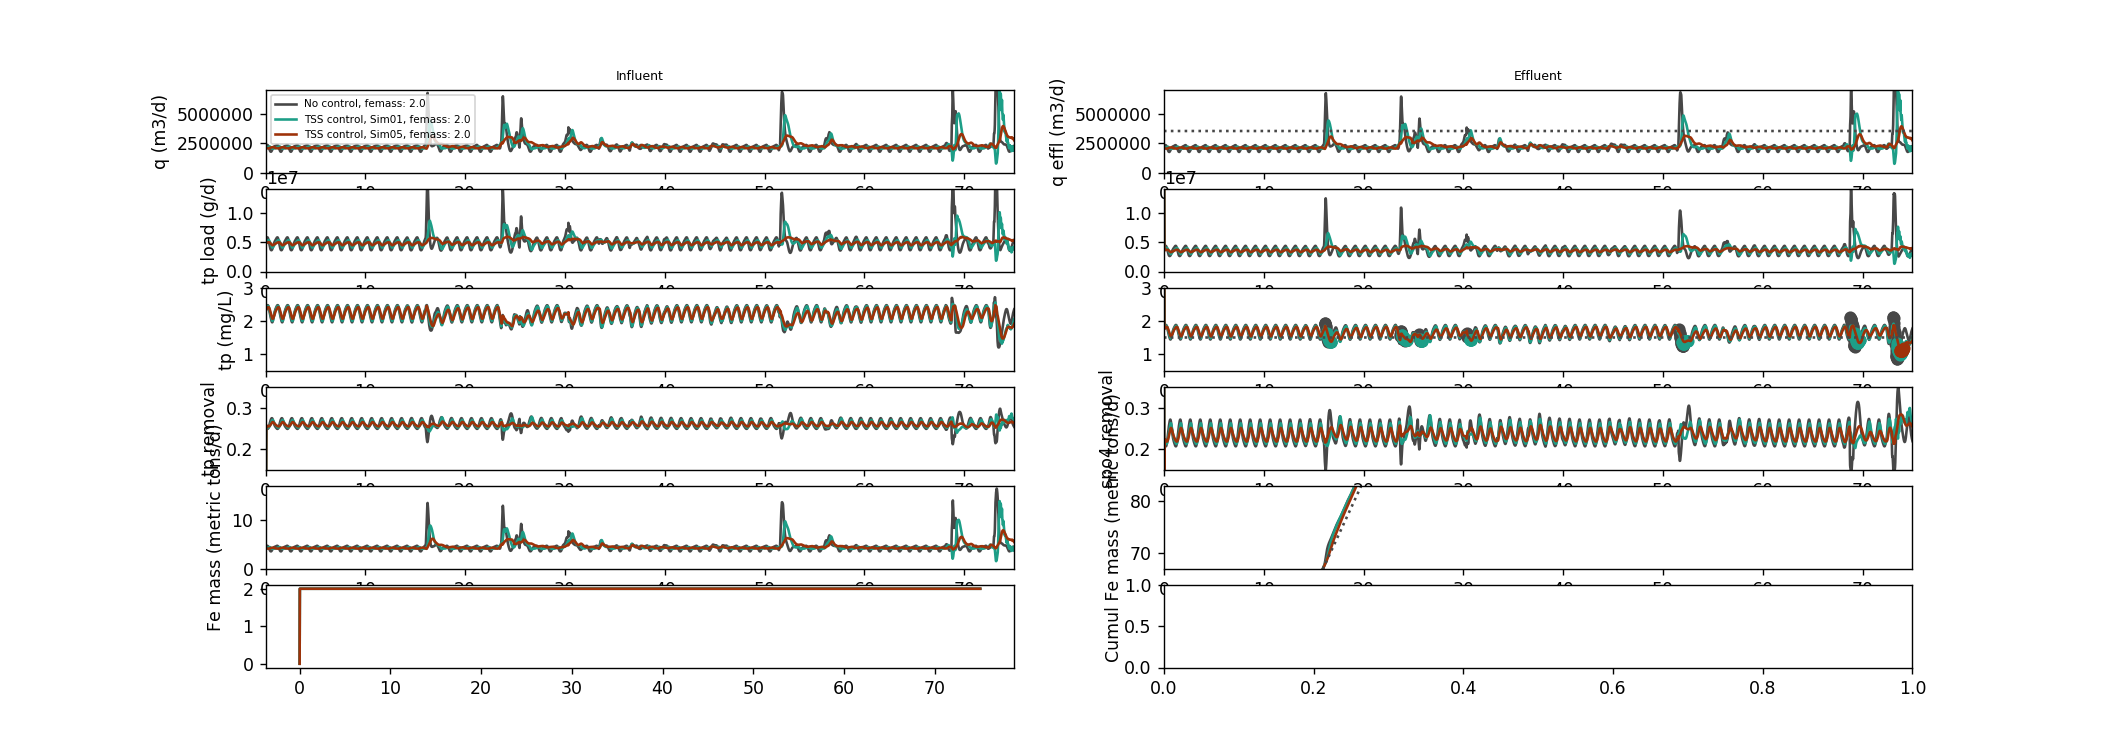

No control, Storm 4

Step magnitude ferric chloride dose: 2.0

230021 TSV file "C:/Users/Sara/Desktop/sewerWRRF/data/storm_influent_edits.tsv" was not unloaded since it has not been loaded.
530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/data/storm_influent_edits.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
Cumulative Fe mass sum: 3600    340.412962
dtype: float64 metric tons
Sum of time indices when overflow: 123
Sum of TP conc when overflow: 190.28361025674266
Average TP conc when overflow: 1.5470212215995338
Max TP conc when overflow: 2.128718778050811
Cumulative overall TP load: 281.5020906945055
Average overall TP concentration: 1.6673306725156134
TSS control, Storm 4, Control sim 01

Step magnitude ferric chloride dose: 2.0

530021 Set: Sumo__Plant__Influent__param__Q to 2.1e+06
530021 Set: Sumo__Plant__Influent__param__T to 20
530021 Set: Sumo__Plant__Influent__param__TCOD to 210
530021 Set: Sumo__Plant__Influent__param__TKN to 20
530021 Set: Sumo__Plant__In

In [7]:
# Initiate figure for timeseries plots
fig, axes = plt.subplots(nrows=6,ncols=2, figsize=(17,6))
plt.rcParams.update({'font.size': 6})

for j in range(0,len(save)):
    for k in stepMags_femass:
        
        ks = [0]
        
        # Specify .tsv for reading (r) diurnal influent data and writing (w) changes to a new file
        if save[j] == 0:
            print('No control, Storm '+stormNo+'\n')
            r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_nc_influent.tsv'
            plotlabel = 'No control'
            savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_nc_femass'+str(k)+'.pkl'
            #savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_nc_femass_5Q045thres.pkl'
        elif save[j] == 1:
            print('Both control, Storm '+stormNo+', Control sim '+controlNo[j]+'\n')
            r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_c_both_'+controlNo[j]+'_influent.tsv'
            plotlabel = 'Both control, Sim'+controlNo[j]
            savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_both_'+controlNo[j]+'_femass'+str(k)+'.pkl'
            #savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_both_'+controlNo[j]+'_femass_5Q045thres.pkl'
        elif save[j] == 2:
            print('Flow control, Storm '+stormNo+', Control sim '+controlNo[j]+'\n')
            r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_c_flow_'+controlNo[j]+'_influent.tsv'
            plotlabel = 'Flow control, Sim'+controlNo[j]
            savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_flow_'+controlNo[j]+'_femass'+str(k)+'.pkl'
            #savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_flow_'+controlNo[j]+'_femass_5Q045thres.pkl'
        elif save[j] == 3:
            print('TSS control, Storm '+stormNo+', Control sim '+controlNo[j]+'\n')
            r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_c_TSS_'+controlNo[j]+'_influent.tsv'
            plotlabel = 'TSS control, Sim'+controlNo[j]
            savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_TSS_'+controlNo[j]+'_femass'+str(k)+'.pkl'
            #savedf_name = 'C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm'+stormNo+'_c_TSS_'+controlNo[j]+'_femass_5Q045thres.pkl'
        
        w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm_influent_edits.tsv'
        
        print('Step magnitude ferric chloride dose: ' + str(k) + '\n')
    
        # Make a change to the original .tsv file
        r_influentTSV_data = pd.read_table(r_influentTSV, sep='\t')
        
        for i in range(0,int(stopTime_days*24*60/30)):
            #if r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] <= 2100000:
            #    k = 1.5
            #else:
            #    k = 0.0000005 * r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] + 0.45
            ks.append(k)
            r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] = k*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
            #if r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] > 3100000:
            #    r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] += 1.*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
            #elif r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i] > 2400000:
            #    r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] += 0.5*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
            #if r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]*r_influentTSV_data["Sumo__Plant__Influent__param__frSPO4_TP"].values[i]*r_influentTSV_data["Sumo__Plant__Influent__param__TP"].values[i] > 4000000:
            #    r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] += 1.5*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
            #elif r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]*r_influentTSV_data["Sumo__Plant__Influent__param__frSPO4_TP"].values[i]*r_influentTSV_data["Sumo__Plant__Influent__param__TP"].values[i] > 3100000:
            #    r_influentTSV_data["Sumo__Plant__Metal1__param__Femass"].values[i] += 1.*r_influentTSV_data["Sumo__Plant__Influent__param__Q"].values[i]
        
        # Write the changed .tsv file to a new file
        with open(w_influentTSV,'w') as write_tsv:
            write_tsv.write(r_influentTSV_data.to_csv(sep='\t', index=False))
        
        # Unload changed .tsv file to Sumo
        command = 'unloadtsv '+ w_influentTSV +' ;'
        sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
        
        # Load changed .tsv file to Sumo
        command = 'loadtsv '+ w_influentTSV +' ;'
        sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
        
        # Rerun Sumo simulation
        t_set = []; femass_set = []
        q_infl_set = []; xtss_infl_set = []; spo4_infl_set = []; tp_infl_set = []
        q_effl_set = []; xtss_effl_set = []; spo4_effl_set = []; tp_effl_set = []
        
        sumo.run_model()
        
        while not sumo.simulation_finished:
            time.sleep(0.01)
        
        # Create dictionary of variables
        data_step = {}
        data_step['t'] = t_set
        data_step['femass'] = femass_set; data_step['feconc'] = ks
        data_step['q_infl'] = q_infl_set; data_step['q_effl'] = q_effl_set
        data_step['xtss_infl'] = xtss_infl_set; data_step['xtss_effl'] = xtss_effl_set
        data_step['spo4_infl'] = spo4_infl_set; data_step['spo4_effl'] = spo4_effl_set
        data_step['tp_infl'] = tp_infl_set; data_step['tp_effl'] = tp_effl_set
        
        # Create a pandas dataframe for this dictionary and index by time (t)
        df_step = pd.DataFrame.from_dict(data_step)
        df_step.set_index('t')
        
        df_step.to_pickle(savedf_name)
        
        # Plot timeseries comparing influent and effluent of each step trial
        axes[0,0].plot(data_step['t'], data_step['q_infl'], label=plotlabel+', femass: '+str(k), color = colors[j])
        axes[0,1].plot(data_step['t'], data_step['q_effl'], label='Effluent, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        #axes[1,0].plot(data_step['t'], data_step['spo4_infl'], label='Influent, '+plotlabel+', femass: '+str(k), color = colors[j])
        #axes[1,1].plot(data_step['t'], data_step['spo4_effl'], label='Effluent, '+plotlabel+', femass: '+str(k), color = colors[j])
        axes[1,0].plot(data_step['t'], np.multiply(data_step['tp_infl'],data_step['q_infl']), label='Influent, '+plotlabel+', femass: '+str(k), color = colors[j])
        axes[1,1].plot(data_step['t'], np.multiply(data_step['tp_effl'],data_step['q_effl']), label='Effluent, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        axes[2,0].plot(data_step['t'], data_step['tp_infl'], label='Influent, '+plotlabel+', femass: '+str(k), color = colors[j])
        axes[2,1].plot(data_step['t'], data_step['tp_effl'], label='Effluent, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        axes[3,0].plot(data_step['t'], np.divide(np.subtract(np.multiply(data_step['tp_infl'],data_step['q_infl']),np.multiply(data_step['tp_effl'],data_step['q_effl'])), np.multiply(data_step['tp_infl'],data_step['q_infl'])), label='TP removal, '+plotlabel+', femass: '+str(k), color = colors[j])
        axes[3,1].plot(data_step['t'], np.divide(np.subtract(np.multiply(data_step['spo4_infl'],data_step['q_infl']),np.multiply(data_step['spo4_effl'],data_step['q_effl'])), np.multiply(data_step['spo4_infl'],data_step['q_infl'])), label='SPO4 removal, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        axes[4,0].plot(data_step['t'], np.divide(data_step['femass'],1000000), label='Femass, '+plotlabel+', femass: '+str(k), color = colors[j])
        cumsumFemass = (pd.Series(np.divide(data_step['femass'],1000000)/24/60*30)).cumsum()
        axes[4,1].plot(data_step['t'], cumsumFemass, label='Femass, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        axes[5,0].plot(data_step['t'], ks, label='Femass, '+plotlabel+', femass: '+str(k), color = colors[j])
        
        print('Cumulative Fe mass sum: '+str(cumsumFemass.tail(1))+' metric tons')
        
        # Summarize results
        peaks_tpl_infl_ind.append(np.argmax(np.multiply(data_step['tp_infl'],data_step['q_infl'])[10:-1])+10)
        peaks_tpl_infl.append(np.multiply(data_step['tp_infl'],data_step['q_infl'])[peaks_tpl_infl_ind[-1]])
        peaks_tpl_infl_time.append(data_step['t'][peaks_tpl_infl_ind[-1]])
        peaks_sp_infl.append(data_step['spo4_infl'][peaks_tpl_infl_ind[-1]])
        
        peaks_tpl_effl_ind.append(np.argmax(np.multiply(data_step['tp_effl'],data_step['q_effl'])[10:-1])+10)
        peaks_tpl_effl.append(np.multiply(data_step['tp_effl'],data_step['q_effl'])[peaks_tpl_effl_ind[-1]])
        peaks_tpl_effl_time.append(data_step['t'][peaks_tpl_effl_ind[-1]])
        peaks_sp_effl.append(data_step['spo4_effl'][peaks_tpl_effl_ind[-1]])
        
        t_count = 0
        tp_sum = 0
        tp_max = 0
        for i in range(0,len(data_step['q_effl'])):
            if data_step['q_effl'][i] > 3520430:
                axes[2,1].plot(data_step['t'][i], data_step['tp_effl'][i], 'o', color = colors[j])
                t_count += 1
                tp_sum += data_step['tp_effl'][i]
                tp_max = np.max([tp_max,data_step['tp_effl'][i]])
        if t_count == 0:
            tp_overflow_avg = 0
        else:
            tp_overflow_avg = tp_sum/t_count
        print('Sum of time indices when overflow: '+str(t_count))
        print('Sum of TP conc when overflow: '+str(tp_sum))
        print('Average TP conc when overflow: '+str(tp_overflow_avg))
        print('Max TP conc when overflow: '+str(tp_max))
        print('Cumulative overall TP load: '+str(np.sum(np.multiply(data_step['tp_effl'],data_step['q_effl']))/1000000/24/60*30))
        print('Average overall TP concentration: '+str(np.average(data_step['tp_effl'])))

plot_starttime = 0
plot_stoptime = 75

axes[0,1].plot(data_step['t'], 3520430*np.ones_like(data_step['t']), ':', color = '#474747',label='equal to 930Mgal/d')
#axes[0,1].set_xlabel('Time')
axes[0,0].set_ylabel('q (m3/d)'); axes[0,1].set_ylabel('q effl (m3/d)')
axes[0,0].set_xlim(plot_starttime,plot_stoptime); axes[0,1].set_xlim(plot_starttime,plot_stoptime)
axes[0,0].set_ylim(0,7000000); axes[0,1].set_ylim(0,7000000)
axes[0,0].legend(loc='upper left')
axes[0,0].set_title('Influent')
axes[0,1].set_title('Effluent')

#axes[1,1].set_xlabel('Time')
#axes[1,0].set_ylabel('spo4 (mg/L)'); #axes[1,1].set_ylabel('spo4 effl (mg/L)')
#axes[1,0].set_xlim(plot_starttime,plot_stoptime); axes[1,1].set_xlim(plot_starttime,plot_stoptime)
#axes[1,0].set_ylim(0.,1.5); axes[1,1].set_ylim(0.,1.5)
#axes[1].legend()
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('tp load (g/d)')
axes[1,0].set_xlim(plot_starttime,plot_stoptime); axes[1,1].set_xlim(plot_starttime,plot_stoptime)
axes[1,0].set_ylim(0,14000000); axes[1,1].set_ylim(0,14000000)

axes[2,1].plot(data_step['t'], 1.5*np.ones_like(data_step['t']), ':', color = '#474747')
#axes[2,1].set_xlabel('Time')
axes[2,0].set_ylabel('tp (mg/L)'); #axes[2,1].set_ylabel('tp effl (mg/L)')
axes[2,0].set_xlim(plot_starttime,plot_stoptime); axes[2,1].set_xlim(plot_starttime,plot_stoptime)
axes[2,0].set_ylim(0.5,3); axes[2,1].set_ylim(0.5,3)
#axes[2].legend()

axes[3,0].set_xlabel('Time')
axes[3,0].set_ylabel('tp removal')
axes[3,0].set_xlim(plot_starttime,plot_stoptime)
axes[3,0].set_ylim(0.15,0.35)
#axes[3].legend()

axes[3,1].set_xlabel('Time')
axes[3,1].set_ylabel('spo4 removal')
axes[3,1].set_xlim(plot_starttime,plot_stoptime)
axes[3,1].set_ylim(0.15,0.35)

axes[4,0].set_xlabel('Time')
axes[4,0].set_ylabel('Fe mass (metric tons/d)')
axes[4,0].set_xlim(plot_starttime,plot_stoptime)
axes[4,0].set_ylim(0,17)

axes[4,1].plot([0,75],[0,315],':', color = '#474747')
axes[4,1].set_xlabel('Time')
axes[4,1].set_ylabel('Cumul Fe mass (metric tons/d)')
axes[4,1].set_xlim(plot_starttime,plot_stoptime)
axes[4,1].set_ylim(0,350)
axes[4,1].set_ylim(67,83)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
plt.rcParams.update({'font.size': 6})

axes[0].plot(data_step['tp_effl'],np.divide(data_step['femass'],1000000),'.')
axes[0].set_xlim(1,2)

axes[1].plot(data_step['tp_effl'])

In [ ]:
#df_plot = pd.read_pickle("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_nc_femass2.0.pkl")
#df_plot = pd.read_pickle("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_c_TSS_01_femass2.0.pkl")
df_plot = pd.read_pickle("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_c_TSS_05_femass2.0.pkl")

plot_starttime = 15
plot_stoptime = 18

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(3,7))
plt.rcParams.update({'font.size': 8})

axes[0].plot(df_plot['t'], np.divide(df_plot['q_infl'],1000000), color = colors[0])
axes[0].set_ylabel('WRRF Infl\nFlow (Mm3/d)')
axes[0].set_xlim(plot_starttime,plot_stoptime)
axes[0].set_ylim(0,7)
axes[0].set_title('Strong attenuation')

axes[1].plot(data_step['t'], np.divide(np.multiply(df_plot['spo4_effl'],df_plot['q_effl']),1000000), label='SPO4', color = colors[0])
axes[1].plot(data_step['t'], np.divide(np.multiply(df_plot['tp_effl'],df_plot['q_effl']),1000000), label='TP', color = colors[1])
axes[1].set_ylabel('PE SPO4 and\nTP Load (Mg/d)')
axes[1].set_xlim(plot_starttime,plot_stoptime)
axes[1].set_ylim(0,14)
axes[1].legend(loc='upper right')

axes[2].plot(df_plot['t'], df_plot['spo4_effl'], label='SPO4', color = colors[0])
axes[2].plot(df_plot['t'], df_plot['tp_effl'], label='TP', color = colors[1])
axes[2].set_ylabel('PE SPO4 and\nTP (mg/L)', wrap=True)
axes[2].set_xlim(plot_starttime,plot_stoptime)
axes[2].set_ylim(0.5,2.5)
axes[2].legend(loc='upper right')

axes[3].plot(df_plot['t'], np.divide(np.subtract(df_plot['spo4_infl'],df_plot['spo4_effl']), df_plot['spo4_infl']), label='SPO4', color = colors[0])
axes[3].plot(df_plot['t'], np.divide(np.subtract(df_plot['tp_infl'],df_plot['tp_effl']), df_plot['tp_infl']), label='TP', color = colors[1])
axes[3].set_xlabel('Time (days)')
axes[3].set_ylabel('PE SPO4 and\nTP Removal', wrap=True)
axes[3].set_xlim(plot_starttime,plot_stoptime)
axes[3].set_ylim(0.1,0.35)
axes[3].legend(loc='upper right')

plt.tight_layout()
#plt.savefig("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_nc_femass2.0.png")
#plt.savefig("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_c_TSS_01_femass2.0.png")
plt.savefig("C:/Users/Sara/Desktop/sewerWRRF/data/results/df_storm1_c_TSS_05_femass2.0.png")

In [ ]:
print(peaks_tpl_infl_ind)
print(peaks_tpl_infl_time)
print(peaks_tpl_infl)
print(peaks_sp_infl)
print(peaks_tpl_effl_ind)
print(peaks_tpl_effl_time)
print(peaks_tpl_effl)
print(peaks_sp_effl)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(stepMags_femass,np.divide(peaks_tpl_effl,1000),'o')
axes[0].set_xlabel('Fe dose concentration (mg/L)')
axes[0].set_ylabel('Peak TP Load (kg/d)')

#axes[1].plot(stepMags_femass,np.divide(np.subtract(peaks_tpl_infl,peaks_tpl_effl),peaks_tpl_infl),'o')
#axes[1].set_xlabel('Fe dose concentration (mg/L)')
#axes[1].set_ylabel('Peak TP Load Removal')

axes[1].plot(stepMags_femass,np.divide(np.subtract(peaks_sp_infl,peaks_sp_effl),peaks_sp_infl),'o')
axes[1].set_xlabel('Fe dose concentration (mg/L)')
axes[1].set_ylabel('SPO4 Concentration (mg/L) Reduction')